In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import seaborn as sb
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, Dense, Dropout, MaxPooling1D, Input
import matplotlib.pyplot as plt

In [2]:
def load_realtime_data(stock_symbol, start_date):
    data = yf.download(stock_symbol, start=start_date, end=pd.Timestamp.now(), interval='1d')
    return data

In [3]:
def preprocess_data(data, time_step=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

    X_data, y_data = [], []
    for i in range(time_step, len(scaled_data)):
        X_data.append(scaled_data[i-time_step:i, 0])
        y_data.append(scaled_data[i, 0])
        
    X_data, y_data = np.array(X_data), np.array(y_data)
    X_data = X_data.reshape(X_data.shape[0], X_data.shape[1], 1)
    
    return X_data, y_data, scaler


In [4]:
def split_data(X, y, split_ratio=0.8):
    train_size = int(len(X) * split_ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train, X_test, y_train, y_test

In [5]:
# 4. Build CNN-LSTM Model
def build_model():
    model = Sequential()
    
    # Input layer
    model.add(Input(shape=(60, 1)))
    
    # CNN Layer
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    
    # LSTM Layer
    model.add(LSTM(units=100, return_sequences=False))
    model.add(Dropout(0.3))
    
    # Dense Layers
    model.add(Dense(units=50, activation='relu'))
    model.add(Dense(units=1))  # Output layer
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model
    

In [6]:
def train_model(model, X_train, y_train, epochs=50, batch_size=32):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    return history

In [7]:
def predict_and_inverse_scale(model, X_test, scaler):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)  # Convert back to original scale
    return predictions

In [8]:
def predict_future_price(model, data, scaler, future_date, time_step=60):
    # Get the latest available data
    recent_data = data['Close'].values[-time_step:]
    recent_data = scaler.transform(recent_data.reshape(-1, 1)).reshape(1, time_step, 1)
    
    # Predict the future price
    future_price = model.predict(recent_data)
    future_price = scaler.inverse_transform(future_price)  # Convert back to original scale
    return future_price[0][0]

In [9]:
def plot_predictions(y_test, predictions, scaler, stock_symbol):
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))  # Scale back the test data
    
    plt.figure(figsize=(14, 5))
    plt.plot(y_test, color='blue', label='Actual Stock Price')
    plt.plot(predictions, color='red', label='Predicted Stock Price')
    plt.title(f'Stock Price Prediction for {stock_symbol} (CNN-LSTM)')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()
         # Display the last predicted stock price
    last_predicted_price = predictions[-1][0]
    print(f"Predicted next day stock price for {stock_symbol}: ₹{last_predicted_price:.2f}")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Latest stock data fetched:
Price             Close         High          Low         Open      Volume
Ticker      RELIANCE.NS  RELIANCE.NS  RELIANCE.NS  RELIANCE.NS RELIANCE.NS
Date                                                                      
2025-04-04  1204.699951  1245.449951  1193.150024  1241.099976    17908652
2025-04-07  1165.699951  1171.250000  1114.849976  1132.199951    22156106
2025-04-08  1182.199951  1196.599976  1163.300049  1172.000000    19555040
2025-04-09  1185.349976  1189.800049  1168.000000  1169.500000    10223104
2025-04-11  1218.949951  1222.650024  1195.150024  1195.150024    11224242
Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.0265 - val_loss: 0.0019
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━

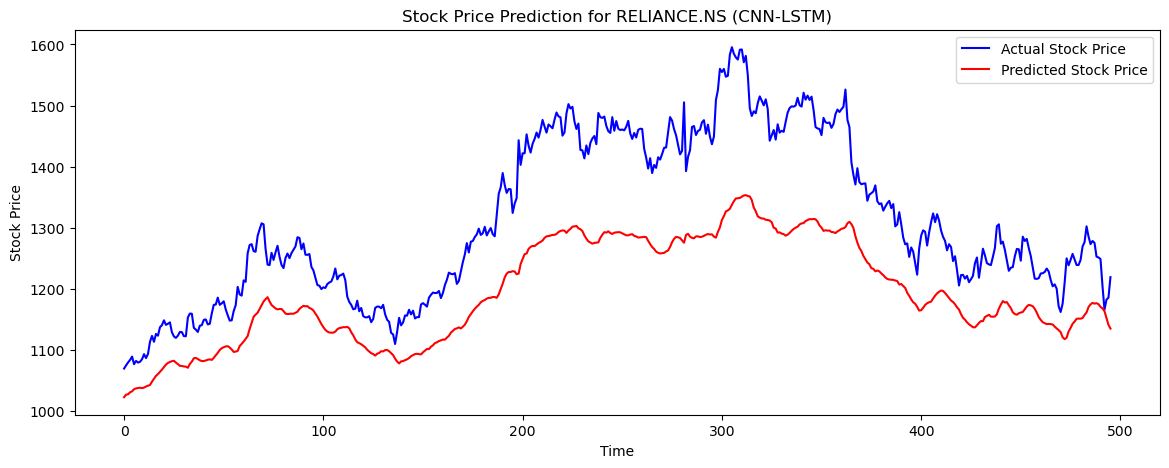

Predicted next day stock price for RELIANCE.NS: ₹1134.72
Prediction complete.


In [10]:
# 9. Main Execution
if __name__ == "__main__":
    stock_symbol = 'RELIANCE.NS'  # Example: Reliance Industries on NSE
    start_date = '2015-01-01'
    future_date = '2024-09-20'

    # Step 1: Load the data
    data = load_realtime_data(stock_symbol, start_date)

    # Check if data is empty
    if data.empty:
        print(f"Failed to fetch data for {stock_symbol}. Please check the ticker or your internet connection.")
    else:
        # Display the latest stock data fetched
        print("Latest stock data fetched:")
        print(data.tail())

        # Step 2: Preprocess the data
        X_data, y_data, scaler = preprocess_data(data)

        # Step 3: Split into training and test sets
        X_train, X_test, y_train, y_test = split_data(X_data, y_data)

        # Step 4: Build the CNN-LSTM model
        model = build_model()

        # Step 5: Train the model
        history = train_model(model, X_train, y_train, epochs=50, batch_size=32)

        # Step 6: Predict stock prices
        predictions = predict_and_inverse_scale(model, X_test, scaler)

        # Step 7: Predict future stock price for a specific date
        future_price = predict_future_price(model, data, scaler, future_date)
        print(f"Predicted stock price for {future_date}: ₹{future_price:.2f}")

        # Step 8: Plot predictions vs actual and display latest stock price
        plot_predictions(y_test, predictions, scaler, stock_symbol)

        print("Prediction complete.")


In [11]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, Dense, Dropout, MaxPooling1D, Input
import matplotlib.pyplot as plt

In [12]:
# 1. Load Real-Time Stock Data
def load_realtime_data(stock_symbol, start_date):
    data = yf.download(stock_symbol, start=start_date, end=pd.Timestamp.now(), interval='1d')
    return data

In [13]:
# 2. Preprocess Data: Normalize and Create Sequences
def preprocess_data(data, time_step=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

    X_data, y_data = [], []
    for i in range(time_step, len(scaled_data)):
        X_data.append(scaled_data[i-time_step:i, 0])
        y_data.append(scaled_data[i, 0])
        
    X_data, y_data = np.array(X_data), np.array(y_data)
    X_data = X_data.reshape(X_data.shape[0], X_data.shape[1], 1)
    
    return X_data, y_data, scaler

In [14]:
# 3. Split Data into Training and Test Sets
def split_data(X, y, split_ratio=0.8):
    train_size = int(len(X) * split_ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train, X_test, y_train, y_test

In [15]:
# 4. Build CNN-LSTM Model
def build_model():
    model = Sequential()
    
    # Input layer
    model.add(Input(shape=(60, 1)))
    
    # CNN Layer
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    
    # LSTM Layer
    model.add(LSTM(units=100, return_sequences=False))
    model.add(Dropout(0.3))
    
    # Dense Layers
    model.add(Dense(units=50, activation='relu'))
    model.add(Dense(units=1))  # Output layer
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [16]:
# 5. Train the Model
def train_model(model, X_train, y_train, epochs=50, batch_size=32):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    return history

In [17]:
# 6. Predict Stock Prices and Convert Back to Original Scale
def predict_and_inverse_scale(model, X_test, scaler):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)  # Convert back to original scale
    return predictions

In [18]:
# 7. Predict Future Stock Price
def predict_future_price(model, data, scaler, future_date, time_step=60):
    # Get the latest available data
    recent_data = data['Close'].values[-time_step:]
    recent_data = scaler.transform(recent_data.reshape(-1, 1)).reshape(1, time_step, 1)
    
    # Predict the future price
    future_price = model.predict(recent_data)
    future_price = scaler.inverse_transform(future_price)  # Convert back to original scale
    return future_price[0][0]

In [19]:
# 8. Plot Predictions and Actual Prices
def plot_predictions(y_test, predictions, scaler, stock_symbol):
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))  # Scale back the test data
    
    plt.figure(figsize=(14, 5))
    plt.plot(y_test, color='blue', label='Actual Stock Price')
    plt.plot(predictions, color='red', label='Predicted Stock Price')
    plt.title(f'Stock Price Prediction for {stock_symbol} (CNN-LSTM)')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

    # Display the last predicted stock price
    last_predicted_price = predictions[-1][0]
    print(f"Predicted next day stock price for {stock_symbol}: ₹{last_predicted_price:.2f}")

[*********************100%***********************]  1 of 1 completed

Latest stock data fetched:
Price              Close          High           Low          Open  \
Ticker     BHARTIARTL.NS BHARTIARTL.NS BHARTIARTL.NS BHARTIARTL.NS   
Date                                                                 
2025-04-04   1743.449951   1770.800049   1740.000000   1754.500000   
2025-04-07   1686.650024   1774.750000   1669.400024   1730.000000   
2025-04-08   1720.400024   1742.300049   1706.800049   1720.699951   
2025-04-09   1715.550049   1726.849976   1711.599976   1719.650024   
2025-04-11   1756.599976   1767.000000   1732.349976   1760.000000   

Price             Volume  
Ticker     BHARTIARTL.NS  
Date                      
2025-04-04       7817334  
2025-04-07      14870388  
2025-04-08       7206935  
2025-04-09       5600666  
2025-04-11       8340002  
Epoch 1/50


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0020 - val_loss: 2.1586e-04
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.0855e-04 - val_loss: 1.9771e-04
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.8137e-04 - val_loss: 1.6195e-04
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.8336e-04 - val_loss: 4.1329e-04
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.5335e-04 - val_loss: 8.4139e-04
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.3469e-04 - val_loss: 6.1308e-04
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.3003e-04 - val_loss: 4.0049e-04
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.3660e-04 - val_loss: 6.5986e-04
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.3632e-04 - val_loss: 1.7883e-04
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 1.6176e-04 - val_loss: 7.3516e-04
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 1.3342e-04 - val_loss: 2

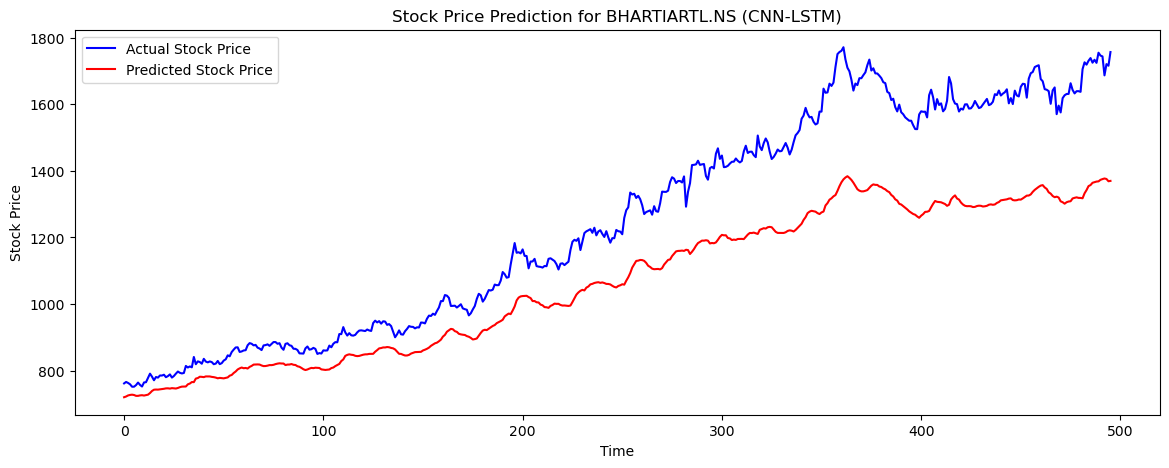

Predicted next day stock price for BHARTIARTL.NS: ₹1369.85
Prediction complete.


In [20]:
# 9. Main Execution
if __name__ == "__main__":
    stock_symbol = 'BHARTIARTL.NS'  # Bharti Airtel stock symbol
    start_date = '2015-01-01'
    future_date = '2025-09-07'

    # Step 1: Load the data
    data = load_realtime_data(stock_symbol, start_date)

    # Display the latest stock data fetched
    print("Latest stock data fetched:")
    print(data.tail())

    # Step 2: Preprocess the data
    X_data, y_data, scaler = preprocess_data(data)

    # Step 3: Split into training and test sets
    X_train, X_test, y_train, y_test = split_data(X_data, y_data)

    # Step 4: Build the CNN-LSTM model
    model = build_model()

    # Optionally, load pre-trained weights if available
    # model.load_weights('model_weights.h5')

    # Step 5: Train the model
    history = train_model(model, X_train, y_train, epochs=50, batch_size=32)

    # Step 6: Predict stock prices
    predictions = predict_and_inverse_scale(model, X_test, scaler)

    # Step 7: Predict future stock price for a specific date
    future_price = predict_future_price(model, data, scaler, future_date)
    print(f"Predicted stock price for {future_date}: ₹{future_price:.2f}")

    # Step 8: Plot predictions vs actual and display latest stock price
    plot_predictions(y_test, predictions, scaler, stock_symbol)

    print("Prediction complete.")

In [21]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, Dense, Dropout, MaxPooling1D, Input
import matplotlib.pyplot as plt

In [22]:
# 1. Load Real-Time Stock Data
def load_realtime_data(stock_symbol, start_date):
    data = yf.download(stock_symbol, start=start_date, end=pd.Timestamp.now(), interval='1d')
    return data

In [23]:
# 2. Preprocess Data: Normalize and Create Sequences
def preprocess_data(data, time_step=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

    X_data, y_data = [], []
    for i in range(time_step, len(scaled_data)):
        X_data.append(scaled_data[i-time_step:i, 0])
        y_data.append(scaled_data[i, 0])
        
    X_data, y_data = np.array(X_data), np.array(y_data)
    X_data = X_data.reshape(X_data.shape[0], X_data.shape[1], 1)
    
    return X_data, y_data, scaler

In [24]:
# 3. Split Data into Training and Test Sets
def split_data(X, y, split_ratio=0.8):
    train_size = int(len(X) * split_ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train, X_test, y_train, y_test


In [25]:
# 4. Build CNN-LSTM Model
def build_model():
    model = Sequential()
    
    # Input layer
    model.add(Input(shape=(60, 1)))
    
    # CNN Layer
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    
    # LSTM Layer
    model.add(LSTM(units=100, return_sequences=False))
    model.add(Dropout(0.3))
    
    # Dense Layers
    model.add(Dense(units=50, activation='relu'))
    model.add(Dense(units=1))  # Output layer
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [26]:
# 5. Train the Model
def train_model(model, X_train, y_train, epochs=50, batch_size=32):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    return history

In [27]:
# 6. Predict Future Stock Prices for Next Week
def predict_future_prices(model, data, scaler, days=7, time_step=60):
    future_prices = []
    
    # Get the latest available data
    recent_data = data['Close'].values[-time_step:]
    recent_data = scaler.transform(recent_data.reshape(-1, 1)).reshape(1, time_step, 1)
    
    for _ in range(days):
        # Predict the next day
        predicted_price = model.predict(recent_data)
        future_prices.append(predicted_price[0][0])
        
        # Update recent_data to include the predicted price
        recent_data = np.roll(recent_data, -1, axis=1)
        recent_data[0, -1, 0] = predicted_price
    
    # Convert back to original scale
    future_prices = scaler.inverse_transform(np.array(future_prices).reshape(-1, 1))
    return future_prices


In [28]:
# 7. Plot Predictions and Actual Prices
def plot_predictions(y_test, predictions, scaler, stock_symbol):
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))  # Scale back the test data
    
    plt.figure(figsize=(14, 5))
    plt.plot(y_test, color='blue', label='Actual Stock Price')
    plt.plot(predictions, color='red', label='Predicted Stock Price')
    plt.title(f'Stock Price Prediction for {stock_symbol} (CNN-LSTM)')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

    # Display the last predicted stock price
    last_predicted_price = predictions[-1][0]
    print(f"Predicted next day stock price for {stock_symbol}: ₹{last_predicted_price:.2f}")

[*********************100%***********************]  1 of 1 completed

Latest stock data fetched:
Price            Close        High         Low        Open    Volume
Ticker          ITC.NS      ITC.NS      ITC.NS      ITC.NS    ITC.NS
Date                                                                
2025-04-04  409.700012  412.799988  404.500000  407.500000  18627592
2025-04-07  406.049988  408.100006  390.149994  390.149994  26762866
2025-04-08  412.549988  415.799988  407.250000  411.899994  18600796
2025-04-09  416.299988  419.049988  411.250000  413.000000  21785572
2025-04-11  421.549988  422.450012  417.000000  420.000000   8939356
Epoch 1/30


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0091 - val_loss: 0.0023
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 5.9245e-04 - val_loss: 0.0021
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 4.9126e-04 - val_loss: 0.0021
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 4.3233e-04 - val_loss: 0.0027
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3.8304e-04 - val_loss: 0.0033
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3.8670e-04 - val_loss: 0.0033
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 3.0218e-04 - val_loss: 0.0025
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 3.3092e-04 - val_loss: 0.0039
Epoch 9/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2.8830e-04 - val_loss: 0.0032
Epoch 10/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2.8259e-04 - val_loss: 0.0031
Epoch 11/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2.9863e-04 - val_loss: 0.0025
Epoch 12/30
50/50 ━━━━━━━━━━━━━━━━

C:\Users\gaura\AppData\Local\Temp\ipykernel_19800\1895988843.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  recent_data[0, -1, 0] = predicted_price


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


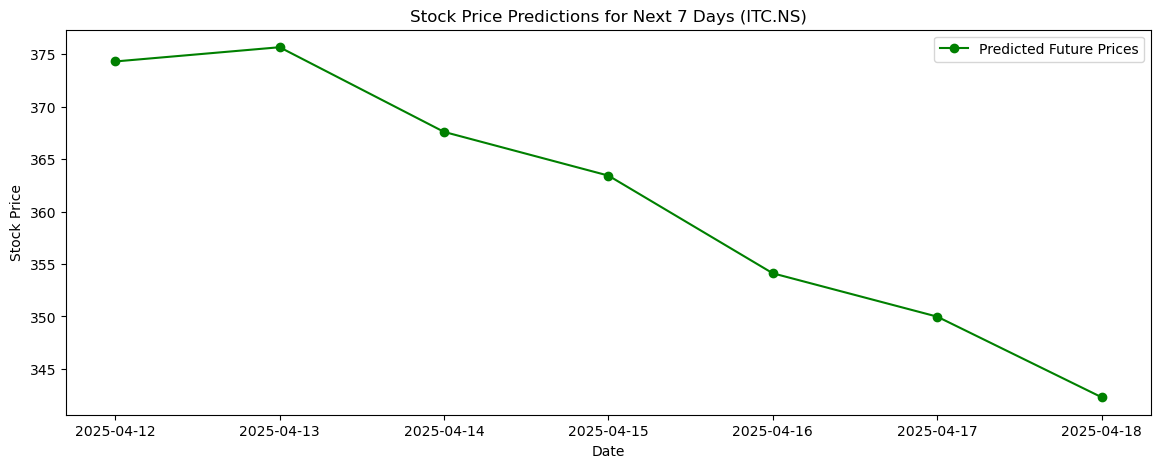

Predicted stock prices for the next 7 days:
2025-04-12: ₹374.30
2025-04-13: ₹375.66
2025-04-14: ₹367.59
2025-04-15: ₹363.42
2025-04-16: ₹354.12
2025-04-17: ₹349.98
2025-04-18: ₹342.31
Prediction complete.


In [29]:
# 8. Main Execution
if __name__ == "__main__":
    stock_symbol = 'ITC.NS'  # Example: ITC Ltd on NSE
    start_date = '2015-01-01'
    days_to_predict = 7  # Number of days to predict

    # Step 1: Load the data
    data = load_realtime_data(stock_symbol, start_date)

    # Display the latest stock data fetched
    print("Latest stock data fetched:")
    print(data.tail())

    # Step 2: Preprocess the data
    X_data, y_data, scaler = preprocess_data(data)

    # Step 3: Split into training and test sets
    X_train, X_test, y_train, y_test = split_data(X_data, y_data)

    # Step 4: Build the CNN-LSTM model
    model = build_model()

    # Optionally, load pre-trained weights if available
    # model.load_weights('model_weights.h5')

    # Step 5: Train the model
    history = train_model(model, X_train, y_train, epochs=30, batch_size=32)

    # Step 6: Predict stock prices for the next week
    future_prices = predict_future_prices(model, data, scaler, days=days_to_predict)
    future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=days_to_predict)

    # Plot future predictions
    plt.figure(figsize=(14, 5))
    plt.plot(future_dates, future_prices, color='green', marker='o', label='Predicted Future Prices')
    plt.title(f'Stock Price Predictions for Next {days_to_predict} Days ({stock_symbol})')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

    print(f"Predicted stock prices for the next {days_to_predict} days:")
    for date, price in zip(future_dates, future_prices):
        print(f"{date.strftime('%Y-%m-%d')}: ₹{price[0]:.2f}")

    print("Prediction complete.")

In [30]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, Dense, Dropout, MaxPooling1D, Input
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [31]:
# 1. Load Recent 52 Weeks of Stock Data
def load_realtime_data(stock_symbol, weeks=520):
    end_date = datetime.now()
    start_date = end_date - timedelta(weeks=weeks)
    data = yf.download(stock_symbol, start=start_date, end=end_date, interval='1d')
    return data

In [32]:
# 2. Preprocess Data: Normalize and Create Sequences
def preprocess_data(data, time_step=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

    X_data, y_data = [], []
    for i in range(time_step, len(scaled_data)):
        X_data.append(scaled_data[i-time_step:i, 0])
        y_data.append(scaled_data[i, 0])
        
    X_data, y_data = np.array(X_data), np.array(y_data)
    X_data = X_data.reshape(X_data.shape[0], X_data.shape[1], 1)
    
    return X_data, y_data, scaler

In [33]:
# 3. Split Data into Training and Test Sets
def split_data(X, y, split_ratio=0.8):
    train_size = int(len(X) * split_ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train, X_test, y_train, y_test

In [34]:
# 4. Build CNN-LSTM Model with Adjusted Architecture
def build_model(time_step=60):
    model = Sequential()
    
    # Input layer
    model.add(Input(shape=(time_step, 1)))
    
    # CNN Layer
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    
    # LSTM Layer
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.3))
    
    # Dense Layers
    model.add(Dense(units=25, activation='relu'))
    model.add(Dense(units=1))  # Output layer
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [35]:
# 5. Train the Model
def train_model(model, X_train, y_train, epochs=100, batch_size=16):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    return history


In [36]:
# 6. Predict Future Stock Prices for Next Week
def predict_future_prices(model, data, scaler, days=7, time_step=60):
    future_prices = []
    
    # Get the latest available data
    recent_data = data['Close'].values[-time_step:]
    recent_data = scaler.transform(recent_data.reshape(-1, 1)).reshape(1, time_step, 1)
    
    for _ in range(days):
        # Predict the next day
        predicted_price = model.predict(recent_data)
        future_prices.append(predicted_price[0][0])
        
        # Update recent_data to include the predicted price
        recent_data = np.roll(recent_data, -1, axis=1)
        recent_data[0, -1, 0] = predicted_price
    
    # Convert back to original scale
    future_prices = scaler.inverse_transform(np.array(future_prices).reshape(-1, 1))
    return future_prices

# 7. Plot Predictions and Actual Prices
def plot_predictions(y_test, predictions, scaler, stock_symbol):
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))  # Scale back the test data
    
    plt.figure(figsize=(14, 5))
    plt.plot(y_test, color='blue', label='Actual Stock Price')
    plt.plot(predictions, color='red', label='Predicted Stock Price')
    plt.title(f'Stock Price Prediction for {stock_symbol} (CNN-LSTM)')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()
      # Display the last predicted stock price
    last_predicted_price = predictions[-1][0]
    print(f"Predicted next day stock price for {stock_symbol}: ₹{last_predicted_price:.2f}")


[*********************100%***********************]  1 of 1 completed


Latest stock data fetched:
Price              Close          High           Low          Open  \
Ticker     TATAMOTORS.NS TATAMOTORS.NS TATAMOTORS.NS TATAMOTORS.NS   
Date                                                                 
2025-04-04    613.849976    650.000000    610.000000    650.000000   
2025-04-07    579.750000    582.000000    535.750000    560.500000   
2025-04-08    588.849976    606.599976    584.200012    591.200012   
2025-04-09    582.900024    594.900024    581.049988    588.000000   
2025-04-11    595.049988    612.799988    591.000000    610.000000   

Price             Volume  
Ticker     TATAMOTORS.NS  
Date                      
2025-04-04      26621179  
2025-04-07      49463598  
2025-04-08      20987855  
2025-04-09      17483412  
2025-04-11      21055814  
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - loss: 0.2217 - val_loss: 0.0116
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0564 - val_loss: 0.0071
Epoch 3/100
8/8 ━━━━━━━━━━━

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0070 - val_loss: 0.0031
Epoch 64/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0092 - val_loss: 0.0037
Epoch 65/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0063 - val_loss: 0.0028
Epoch 66/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0066 - val_loss: 0.0032
Epoch 67/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0046 - val_loss: 0.0030
Epoch 68/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0069 - val_loss: 0.0029
Epoch 69/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0055 - val_loss: 0.0033
Epoch 70/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0068 - val_loss: 0.0031
Epoch 71/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0063 - val_loss: 0.0031
Epoch 72/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0094 - val_loss: 0.0036
Epoch 73/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0073 - val_loss: 0.0032
Epoch 74/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0075 - val_loss: 

C:\Users\gaura\AppData\Local\Temp\ipykernel_19800\482088671.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  recent_data[0, -1, 0] = predicted_price


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


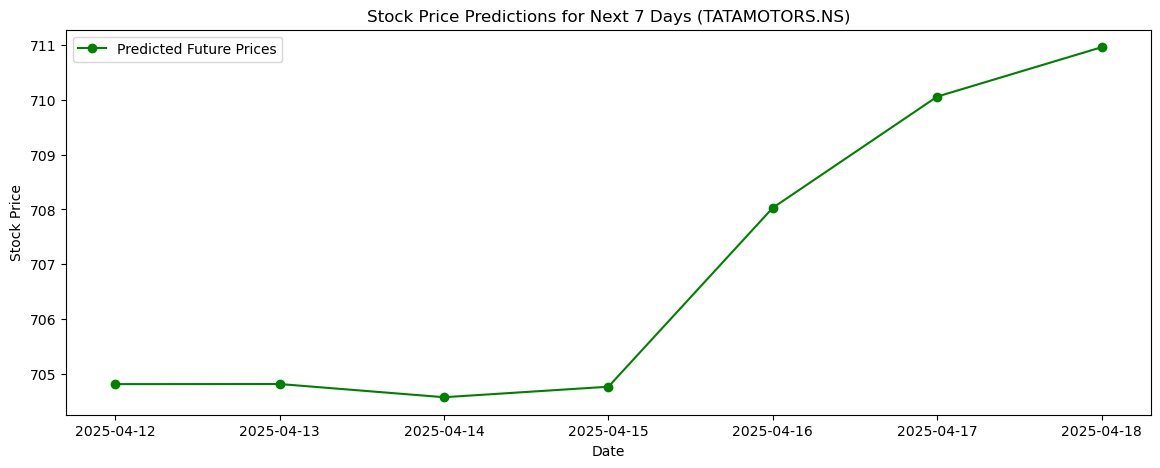

Predicted stock prices for the next 7 days:
2025-04-12: ₹704.82
2025-04-13: ₹704.82
2025-04-14: ₹704.58
2025-04-15: ₹704.77
2025-04-16: ₹708.03
2025-04-17: ₹710.06
2025-04-18: ₹710.96
Prediction complete.


In [37]:
# 8. Main Execution
if __name__ == "__main__":
    stock_symbol = 'TATAMOTORS.NS'  # Bharti Airtel on NSE
    weeks_to_load = 52
    days_to_predict = 7  # Number of days to predict

    # Step 1: Load the data
    data = load_realtime_data(stock_symbol, weeks=weeks_to_load)

    # Display the latest stock data fetched
    print("Latest stock data fetched:")
    print(data.tail())

    # Step 2: Preprocess the data
    X_data, y_data, scaler = preprocess_data(data)

    # Step 3: Split into training and test sets
    X_train, X_test, y_train, y_test = split_data(X_data, y_data)

    # Step 4: Build the CNN-LSTM model
    model = build_model(time_step=60)

    # Optionally, load pre-trained weights if available
    # model.load_weights('model_weights.h5')

    # Step 5: Train the model
    history = train_model(model, X_train, y_train, epochs=100, batch_size=16)

    # Step 6: Predict stock prices for the next week
    future_prices = predict_future_prices(model, data, scaler, days=days_to_predict)
    future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=days_to_predict)

    # Plot future predictions
    plt.figure(figsize=(14, 5))
    plt.plot(future_dates, future_prices, color='green', marker='o', label='Predicted Future Prices')
    plt.title(f'Stock Price Predictions for Next {days_to_predict} Days ({stock_symbol})')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

    print(f"Predicted stock prices for the next {days_to_predict} days:")
    for date, price in zip(future_dates, future_prices):
        print(f"{date.strftime('%Y-%m-%d')}: ₹{price[0]:.2f}")

    print("Prediction complete.")

In [38]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, Dense, Dropout, MaxPooling1D, Input
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [39]:
# 1. Load Recent 52 Weeks of Stock Data
def load_realtime_data(stock_symbol, weeks=52):
    end_date = datetime.now()
    start_date = end_date - timedelta(weeks=weeks)
    data = yf.download(stock_symbol, start=start_date, end=end_date, interval='1d')
    return data


In [40]:
# 2. Preprocess Data: Normalize and Create Sequences
def preprocess_data(data, time_step=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

    X_data, y_data = [], []
    for i in range(time_step, len(scaled_data)):
        X_data.append(scaled_data[i-time_step:i, 0])
        y_data.append(scaled_data[i, 0])
        
    X_data, y_data = np.array(X_data), np.array(y_data)
    X_data = X_data.reshape(X_data.shape[0], X_data.shape[1], 1)
    
    return X_data, y_data, scaler


In [41]:
# 3. Split Data into Training and Test Sets
def split_data(X, y, split_ratio=0.8):
    train_size = int(len(X) * split_ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train, X_test, y_train, y_test

In [42]:
# 4. Build CNN-LSTM Model with Adjusted Architecture
def build_model(time_step=60):
    model = Sequential()
    
    # Input layer
    model.add(Input(shape=(time_step, 1)))
    
    # CNN Layer
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    
    # LSTM Layer
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.3))
    
    # Dense Layers
    model.add(Dense(units=25, activation='relu'))
    model.add(Dense(units=1))  # Output layer
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [43]:
# 5. Train the Model
def train_model(model, X_train, y_train, epochs=100, batch_size=16):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    return history


In [44]:
# 6. Predict Future Stock Prices for Next Week
def predict_future_prices(model, data, scaler, days=7, time_step=60):
    future_prices = []
    
    # Get the latest available data
    recent_data = data['Close'].values[-time_step:]
    recent_data = scaler.transform(recent_data.reshape(-1, 1)).reshape(1, time_step, 1)
    
    for _ in range(days):
        # Predict the next day
        predicted_price = model.predict(recent_data)
        future_prices.append(predicted_price[0][0])
        
        # Update recent_data to include the predicted price
        recent_data = np.roll(recent_data, -1, axis=1)
        recent_data[0, -1, 0] = predicted_price
    
    # Convert back to original scale
    future_prices = scaler.inverse_transform(np.array(future_prices).reshape(-1, 1))
    return future_prices


In [45]:
# 7. Plot Predictions and Actual Prices
def plot_predictions(y_test, predictions, scaler, stock_symbol):
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))  # Scale back the test data
    
    plt.figure(figsize=(14, 5))
    plt.plot(y_test, color='blue', label='Actual Stock Price')
    plt.plot(predictions, color='red', label='Predicted Stock Price')
    plt.title(f'Stock Price Prediction for {stock_symbol} (CNN-LSTM)')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

    # Display the last predicted stock price
    last_predicted_price = predictions[-1][0]
    print(f"Predicted next day stock price for {stock_symbol}: ₹{last_predicted_price:.2f}")

[*********************100%***********************]  1 of 1 completed


Latest stock data fetched:
Price              Close          High           Low          Open  \
Ticker     BHARTIARTL.NS BHARTIARTL.NS BHARTIARTL.NS BHARTIARTL.NS   
Date                                                                 
2025-04-04   1743.449951   1770.800049   1740.000000   1754.500000   
2025-04-07   1686.650024   1774.750000   1669.400024   1730.000000   
2025-04-08   1720.400024   1742.300049   1706.800049   1720.699951   
2025-04-09   1715.550049   1726.849976   1711.599976   1719.650024   
2025-04-11   1756.599976   1767.000000   1732.349976   1760.000000   

Price             Volume  
Ticker     BHARTIARTL.NS  
Date                      
2025-04-04       7817334  
2025-04-07      14870388  
2025-04-08       7206935  
2025-04-09       5600666  
2025-04-11       8340002  
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 0.3828 - val_loss: 0.0739
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0504 - val_loss: 0.0327
Epoch 3/100
8/8 ━━━━━━━━━━━━

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0089 - val_loss: 0.0050
Epoch 64/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0074 - val_loss: 0.0018
Epoch 65/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0100 - val_loss: 0.0031
Epoch 66/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0075 - val_loss: 0.0024
Epoch 67/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0073 - val_loss: 0.0041
Epoch 68/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0093 - val_loss: 0.0017
Epoch 69/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0090 - val_loss: 0.0019
Epoch 70/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0075 - val_loss: 0.0019
Epoch 71/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0081 - val_loss: 0.0023
Epoch 72/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0075 - val_loss: 0.0025
Epoch 73/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0076 - val_loss: 0.0021
Epoch 74/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0083 - val_loss: 

C:\Users\gaura\AppData\Local\Temp\ipykernel_19800\1895988843.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  recent_data[0, -1, 0] = predicted_price


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


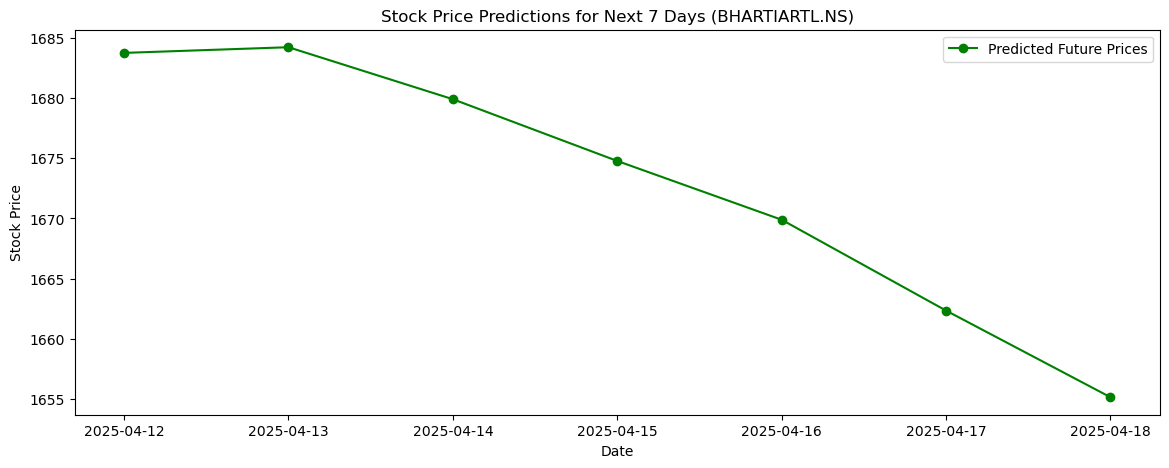

Predicted stock prices for the next 7 days:
2025-04-12: ₹1683.74
2025-04-13: ₹1684.21
2025-04-14: ₹1679.90
2025-04-15: ₹1674.77
2025-04-16: ₹1669.89
2025-04-17: ₹1662.35
2025-04-18: ₹1655.15
Prediction complete.


In [46]:
# 8. Main Execution
if __name__ == "__main__":
    stock_symbol = 'BHARTIARTL.NS'  # Bharti Airtel on NSE
    weeks_to_load = 52
    days_to_predict = 7  # Number of days to predict

    # Step 1: Load the data
    data = load_realtime_data(stock_symbol, weeks=weeks_to_load)

    # Display the latest stock data fetched
    print("Latest stock data fetched:")
    print(data.tail())

    # Step 2: Preprocess the data
    X_data, y_data, scaler = preprocess_data(data)

    # Step 3: Split into training and test sets
    X_train, X_test, y_train, y_test = split_data(X_data, y_data)

    # Step 4: Build the CNN-LSTM model
    model = build_model(time_step=60)

    # Optionally, load pre-trained weights if available
    # model.load_weights('model_weights.h5')

    # Step 5: Train the model
    history = train_model(model, X_train, y_train, epochs=100, batch_size=16)

    # Step 6: Predict stock prices for the next week
    future_prices = predict_future_prices(model, data, scaler, days=days_to_predict)
    future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=days_to_predict)

    # Plot future predictions
    plt.figure(figsize=(14, 5))
    plt.plot(future_dates, future_prices, color='green', marker='o', label='Predicted Future Prices')
    plt.title(f'Stock Price Predictions for Next {days_to_predict} Days ({stock_symbol})')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

    print(f"Predicted stock prices for the next {days_to_predict} days:")
    for date, price in zip(future_dates, future_prices):
        print(f"{date.strftime('%Y-%m-%d')}: ₹{price[0]:.2f}")

    print("Prediction complete.")